`cd project/seniorthesis/notebooks`

`conda list PyCO2SYS`

`pip install PyCO2SYS`

`pip install git+https://github.com/jbusecke/cmip6_preprocessing.git`

`mv *.png ../figures`

In [1]:
import xarray as xr
import xesmf as xe
from cmip6_preprocessing.preprocessing import combined_preprocessing
# import PyCO2SYS as pyco2 # i have to install this package through terminal for it to work
import intake
import matplotlib.pyplot as plt
import numpy as np
import warnings
import gsw
from cmip6_preprocessing.postprocessing import combine_datasets
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import cmocean
import matplotlib.path as mpath
from cmip6_preprocessing.postprocessing import combine_datasets
from cmip6_preprocessing.postprocessing import merge_variables
from dask.diagnostics import ProgressBar
from xgcm import Grid
from xhistogram.xarray import histogram
import pandas as pd

In [2]:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")

variables = ['siconc'] # sea ice thickness (m)
z_kwargs = {'consolidated': True, 'use_cftime': True}
query = dict(experiment_id=['historical'], 
             table_id=['SImon'], 
             variable_id=variables,
             grid_label=['gn'],
              source_id=['IPSL-CM6A-LR', 
#                          'MPI-ESM1-2-LR', 
                         'CNRM-ESM2-1', 
                         'CanESM5', 
#                          'MPI-ESM1-2-HR', 
#                          'CMCC-ESM2', 
#                          'GISS-E2-1-G', 
                         'UKESM1-0-LL',
#                          'ACCESS-ESM1-5', 
                         'CanESM5-CanOE' 
#                          'GISS-E2-1-G-CC',
#                          'MPI-ESM-1-2-HAM'
                        ]
            )


cat = col.search(**query)

# print(cat.df['source_id'].unique())
dd_gn = cat.to_dataset_dict(zarr_kwargs=z_kwargs, storage_options={'token': 'anon'},
                                preprocess=combined_preprocessing, aggregate=False)

dd_gn = merge_variables(dd_gn)
# list(dd_new.keys())

temp={}
for name,item in dd_gn.items():
    #print(name)
    #print(item.data_vars)
    present = item.data_vars
    if all(i in present for i in variables):
        #print(name)
        temp[name]=item
dd_gn = temp


def pick_first_member(ds_list, **kwargs):
    return ds_list[0]

dd_gn = combine_datasets(
    dd_gn,
    pick_first_member,
    match_attrs=['source_id', 'grid_label', 'experiment_id', 'table_id']
)
list(dd_gn.keys())
# dd_new_new_gn

# Regrid
targetgrid_ds = xe.util.grid_global(1.0, 1.0)
targetgrid_ds['lon'] = targetgrid_ds['lon']+180
targetgrid_ds['lon_b'] = targetgrid_ds['lon_b']+180
newcoords = {'x':targetgrid_ds['lon'][0,:],'y':targetgrid_ds['lat'][:,0]}

dd_regrid={}
for name,item in dd_gn.items():
    regridder = xe.Regridder(item, targetgrid_ds, 'bilinear', 
                         periodic=True, ignore_degenerate=True)
    ds_regridded = regridder(item).assign_coords(**newcoords).chunk({'time':120})
    dd_regrid[name]=ds_regridded
list(dd_regrid.keys())


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:496: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:496: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:496: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:496: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply

['CNRM-ESM2-1.gn.historical.SImon',
 'CanESM5.gn.historical.SImon',
 'UKESM1-0-LL.gn.historical.SImon',
 'IPSL-CM6A-LR.gn.historical.SImon',
 'CanESM5-CanOE.gn.historical.SImon']

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


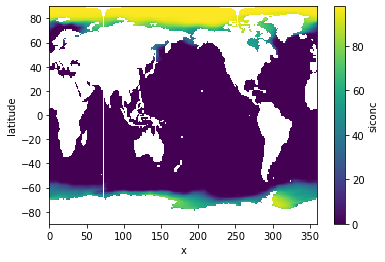

In [3]:
dd_regrid['CNRM-ESM2-1.gn.historical.SImon'].isel(time = slice(0,239)).mean('time', keep_attrs=True).siconc.plot()
# .sithick.isel(time = 1979).mean('time', keep_attrs=True).plot()

In [3]:
variables = ['siconc'] # sea ice thickness (m)
z_kwargs = {'consolidated': True, 'use_cftime': True}
query = dict(experiment_id=['historical'], 
             table_id=['SImon'],  
             variable_id=variables,
             grid_label=['gr'],
              source_id=['GFDL-ESM4', 'CESM2-WACCM', 'CESM2', 
                         'CESM2-FV2', 'MRI-ESM2-0', 
                         'GFDL-CM4', 'CESM2-WACCM-FV2']
            )


cat = col.search(**query)

# print(cat.df['source_id'].unique())
dd_gr = cat.to_dataset_dict(zarr_kwargs=z_kwargs, storage_options={'token': 'anon'},
                                preprocess=combined_preprocessing, aggregate=False)

dd_gr = merge_variables(dd_gr)

temp={}
for name,item in dd_gr.items():
    #print(name)
    #print(item.data_vars)
    present = item.data_vars
    if all(i in present for i in variables):
        #print(name)
        temp[name]=item
dd_gr = temp
# list(dd_new_gr.keys())

dd_gr = combine_datasets(
    dd_gr,
    pick_first_member,
    match_attrs=['source_id', 'grid_label', 'experiment_id', 'table_id']
)
list(dd_gr.keys())
# dd_new_new_gr


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


['GFDL-ESM4.gr.historical.SImon', 'GFDL-CM4.gr.historical.SImon']

In [5]:
dd = {**dd_gr, **dd_regrid}

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.

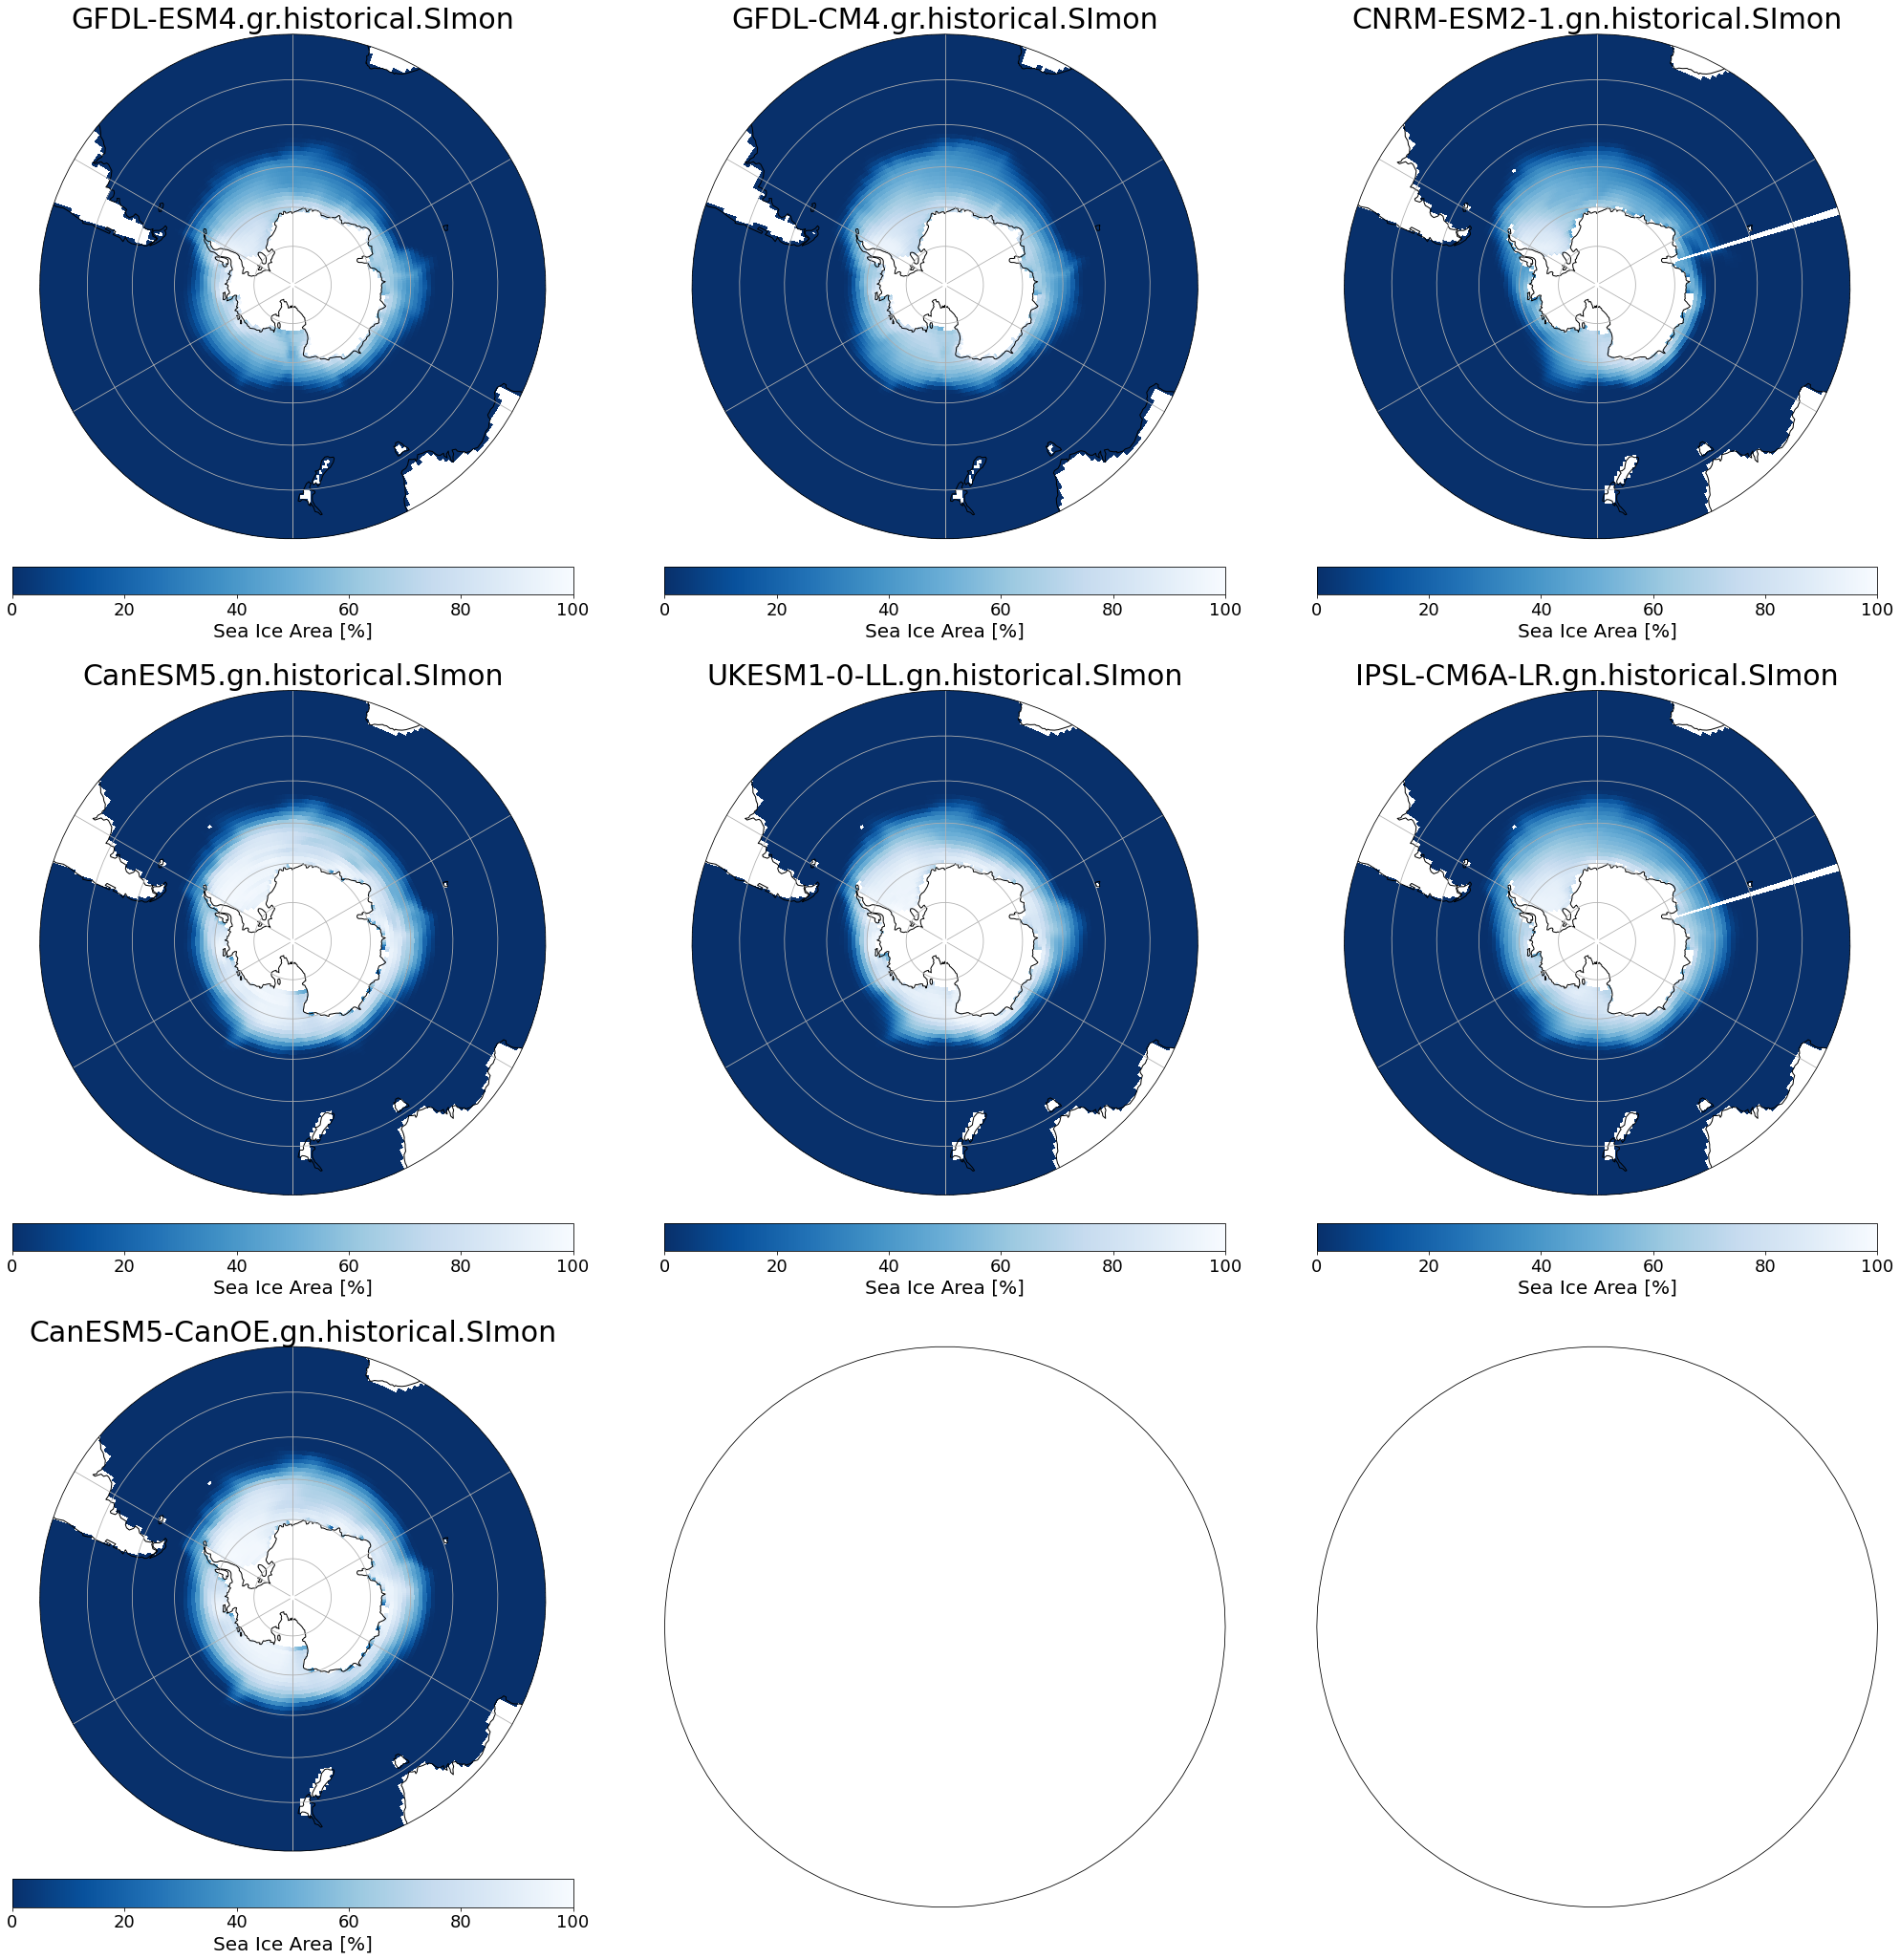

In [9]:
fig, axarr = plt.subplots(nrows = 3, ncols=3, figsize=[30,30], subplot_kw={'projection':ccrs.SouthPolarStereo()})
fig.tight_layout(pad = 10)
crs_plot = ccrs.SouthPolarStereo()
crs_source = ccrs.PlateCarree()

ax_idx = 0 # index for your axes array
for name, ds in dd.items():

    ax = axarr.flat[ax_idx]
    #fig,ax = plt.subplots(figsize=(10,10),subplot_kw={'projection':crs_plot})
#     ax.add_feature(cfeature.LAND,zorder=10,facecolor='darkgray')
    ax.set_extent([-180, 180, -90, -30], crs_source)
    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    
    ax.gridlines()
    ax.coastlines()
    
    title=name
    ax.set_title(title,fontsize=30,pad = 1)
    
    lat = ds['siconc'].lat.transpose('y','x')
    lon = ds['siconc'].lon.transpose('y','x')
    X = lon
    Y = lat
    
#     conversion = 3.1536e7 * 83.3
    # 3.1536e7 seconds per year
    # 83.3 mol C per kg -- 12 gC/mol
    
    Z = ds['siconc'].isel(time = slice(0,239)).mean('time',keep_attrs=True)
#     (time = slice(1740,1979)).mean('time', keep_attrs=True)
#     rho = ds['sigma2'].isel(lev = 0)
#     rho = rho.transpose('x','y')
#     rho.assign_coords({'lat': Y})
#     rho.assign_coords({'lon': X})
#     rho = rho.transpose('x','y')
#     rho.assign_coords({'lat': Y})
#     rho.assign_coords({'lon': X})
# #     rho = rho.transpose('y','x')
# #     print(Z)
# #     print(rho)
    
    
    im = ax.pcolormesh(X,Y,1*Z,cmap='Blues_r', transform = crs_source, shading = 'auto', vmin = 0, vmax = 100)
#     if name == 'UKESM1-0-LL.gn.historical.Omon' or name =='CanESM5-CanOE.gn.historical.Omon' or name =='CNRM-ESM2-1.gn.historical.Omon' or name == 'CanESM5.gn.historical.Omon' or name == 'IPSL-CM6A-LR.gn.historical.Omon':
#         CS = ax.contour(rho.lon,rho.lat,rho,transform=crs_source,levels=[35, 35.5, 36, 36.5, 36.8],colors='g', linewidths = 3)
#     else:
#         CS = ax.contour(rho.lon.transpose('y','x'),rho.lat.transpose('y','x'),rho.transpose('y','x'),transform=crs_source,levels=[35, 35.5, 36, 36.5],colors='g', linewidths = 3)
    
    cbar_label = 'Sea Ice Area [%]'
    cbar = plt.colorbar(im,ax = ax, orientation='horizontal',fraction = 0.05, pad=0.05)
    cbar.set_label(cbar_label, fontsize = 20)
    cbar.ax.tick_params(labelsize=18)
#     ax.clabel(CS, inline=1, fontsize=24)
    
    ax_idx += 1


In [11]:
variables = ['siextents'] # sea ice thickness (m)
z_kwargs = {'consolidated': True, 'use_cftime': True}
query = dict(experiment_id=['historical'], 
             table_id=['SImon'],  
             variable_id=variables,
             grid_label=['gr'],
              source_id=['GFDL-ESM4', 'CESM2-WACCM', 'CESM2', 
                         'CESM2-FV2', 'MRI-ESM2-0', 
                         'GFDL-CM4', 'CESM2-WACCM-FV2']
            )


cat = col.search(**query)

# print(cat.df['source_id'].unique())
dd_gr = cat.to_dataset_dict(zarr_kwargs=z_kwargs, storage_options={'token': 'anon'},
                                preprocess=combined_preprocessing, aggregate=False)

dd_gr = merge_variables(dd_gr)

temp={}
for name,item in dd_gr.items():
    #print(name)
    #print(item.data_vars)
    present = item.data_vars
    if all(i in present for i in variables):
        #print(name)
        temp[name]=item
dd_gr = temp
# list(dd_new_gr.keys())

dd_gr = combine_datasets(
    dd_gr,
    pick_first_member,
    match_attrs=['source_id', 'grid_label', 'experiment_id', 'table_id']
)
list(dd_gr.keys())
# dd_new_new_gr

[]